### Keras DNN으로 집값 예측하기

1. 패키지 수입 및 파라미터 설정

In [1]:
# 수입
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns                   # import : 특정 패키지를 가지고 온다.

from time import time                   # from : 패키지에 특정 함수만 가지고 온다. 
from keras.models import Sequential          
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# 파라미터
MY_HIDDEN = 900    # 뉴런 갯수
MY_EPOCH = 200      # 데이터를 500번 반복 학습

#pd.set_option('display.max_columns', None)     ## 생략된 부분을 보여줌

2. 데이터 처리

In [3]:
# 데이터 읽기
raw = pd.read_csv('/content/drive/MyDrive/data/housing.csv')

# 데이터 샘플 10개 출력
print(raw.head(10))

# 데이터 통계 출력
print(raw.describe())     # describe : 데이터의 통계를 내라

      CRIM    ZN  INDUS  CHAS    NOX  ...  RAD  TAX  PTRATIO  LSTAT  MEDV
0  0.00632  18.0   2.31     0  0.538  ...    1  296     15.3   4.98  24.0
1  0.02731   0.0   7.07     0  0.469  ...    2  242     17.8   9.14  21.6
2  0.02729   0.0   7.07     0  0.469  ...    2  242     17.8   4.03  34.7
3  0.03237   0.0   2.18     0  0.458  ...    3  222     18.7   2.94  33.4
4  0.06905   0.0   2.18     0  0.458  ...    3  222     18.7   5.33  36.2
5  0.02985   0.0   2.18     0  0.458  ...    3  222     18.7   5.21  28.7
6  0.08829  12.5   7.87     0  0.524  ...    5  311     15.2  12.43  22.9
7  0.14455  12.5   7.87     0  0.524  ...    5  311     15.2  19.15  27.1
8  0.21124  12.5   7.87     0  0.524  ...    5  311     15.2  29.93  16.5
9  0.17004  12.5   7.87     0  0.524  ...    5  311     15.2  17.10  18.9

[10 rows x 13 columns]
             CRIM          ZN       INDUS  ...     PTRATIO       LSTAT        MEDV
count  506.000000  506.000000  506.000000  ...  506.000000  506.000000  506.000

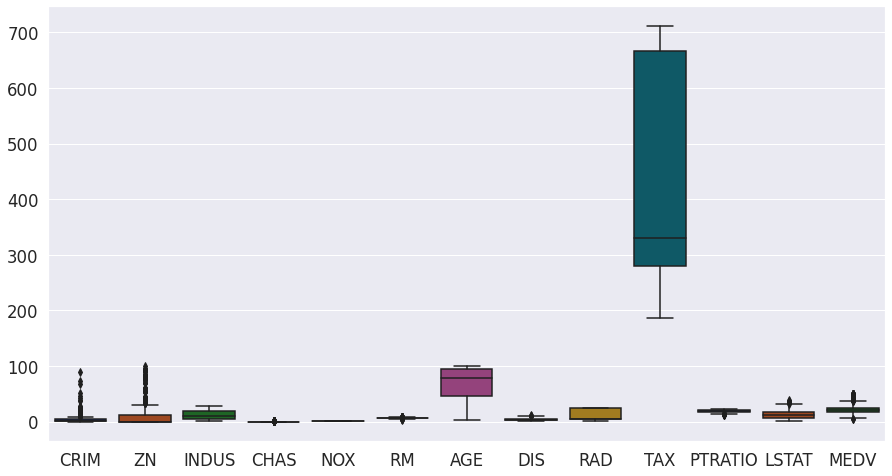

In [4]:
# 데이터 시각화
plt.figure(figsize=(15, 8))   ## 15 by 8의 크기의 차트를 넣어줌
sns.set(font_scale=1.5)
sns.boxplot(data=raw, palette='dark')

In [5]:
# Z-점수 정규화
scaler = StandardScaler()
Z_data = scaler.fit_transform(raw)    # Z_data가 pandas에서 numpy로 넘어감. -> 칼럼 이름이 지워져서 숫자로 변환됨
                                      # fit_transform : 정규화를 진행하는 함수                         
# 데이터 형식 출력
print(type(raw))
print(type(Z_data))

# numpy를 pandas로 재전환
Z_data = pd.DataFrame(Z_data)
print(type(Z_data))

# Z-점수 정규화 된 데이터 샘플 출력
print(Z_data.head(10))    # 전과 후 데이터의 차이 값의 범위의 폭이 좁아졌다.
print(Z_data.describe())  # Z-점수 정규화 : 표준편차(std)가 1로 바뀜, 평균값이 0으로 바뀐다. (종모양)
                          #  => 모든 요소들의 범위가 비슷해짐

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
         0         1         2   ...        10        11        12
0 -0.419782  0.284830 -1.287909  ... -1.459000 -1.075562  0.159686
1 -0.417339 -0.487722 -0.593381  ... -0.303094 -0.492439 -0.101524
2 -0.417342 -0.487722 -0.593381  ... -0.303094 -1.208727  1.324247
3 -0.416750 -0.487722 -1.306878  ...  0.113032 -1.361517  1.182758
4 -0.412482 -0.487722 -1.306878  ...  0.113032 -1.026501  1.487503
5 -0.417044 -0.487722 -1.306878  ...  0.113032 -1.043322  0.671222
6 -0.410243  0.048772 -0.476654  ... -1.505237 -0.031268  0.039964
7 -0.403696  0.048772 -0.476654  ... -1.505237  0.910700  0.497082
8 -0.395935  0.048772 -0.476654  ... -1.505237  2.421774 -0.656595
9 -0.400729  0.048772 -0.476654  ... -1.505237  0.623344 -0.395385

[10 rows x 13 columns]
                 0             1   ...            11            12
count  5.060000e+02  5.060000e+02  ...  5.060000e+02  5.060000e+02
mean 

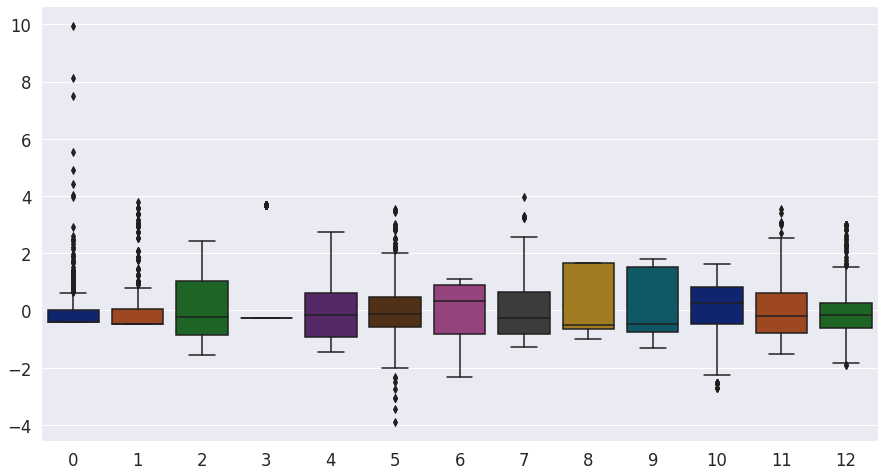

In [6]:
plt.figure(figsize=(15, 8))   ## 15 by 8의 크기의 차트를 넣어줌
sns.set(font_scale=1.5)
sns.boxplot(data=Z_data, palette='dark')

In [7]:
# 데이터 모양 출력
print('분리 전 : ', Z_data.shape)   # >>(506, 13) : 행렬, 506:동네의 개수, 13:영향요소

# 데이터를 입력과 출력으로 분리
X_data = Z_data.drop(12, axis=1)  # X_data는 열에서 맨 오른쪽 하나를 제외 
                                  # -> 12번째 칼럼을 지운다. axis = 1은 raw를 지움, 0은 columns
Y_data = Z_data[12]               # 출력은 MEDV컬럼만 취해라

#X_data = Z_data.drop(6, axis=1)
#Y_data = Z_data[6]

print('분리 후 : ')
print(X_data.shape)
print(Y_data.shape)

분리 전 :  (506, 13)
분리 후 : 
(506, 12)
(506,)


In [8]:
# 데이터 4분할
X_train, X_test, Y_train, Y_test = train_test_split(X_data, 
                                                    Y_data,
                                                    train_size = 0.7)

# 최종 데이터 모양 출력
print('학습용 입력 데이터 모양 : ', X_train.shape)
print('학습용 출력 데이터 모양 : ', Y_train.shape)
print('평가용 입력 데이터 모양 : ', X_test.shape)
print('평가용 출력 데이터 모양 : ', Y_test.shape)

학습용 입력 데이터 모양 :  (354, 12)
학습용 출력 데이터 모양 :  (354,)
평가용 입력 데이터 모양 :  (152, 12)
평가용 출력 데이터 모양 :  (152,)


3. 인공 신경망 구현

In [9]:
model = Sequential()

input = X_train.shape[1]  # 12

# 입력층과 은닉층 1 추가
model.add(Dense(units=MY_HIDDEN, 
                input_dim=input,
                activation = 'relu'))
# 은닉층 2 추가
model.add(Dense(units=MY_HIDDEN,
                activation = 'relu'))

# 출력층 추가
model.add(Dense(units=1))

print('DNN 요약')
model.summary()   # summary에서는 입력층을 출력하지 않음. dense,_1: 은닉층1,2  dense_2 : 출력층 

DNN 요약
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 900)               11700     
_________________________________________________________________
dense_1 (Dense)              (None, 900)               810900    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 901       
Total params: 823,501
Trainable params: 823,501
Non-trainable params: 0
_________________________________________________________________


4. 인공 신경망 학습

In [10]:
# 학습 환경 설정
model.compile(optimizer='sgd',
              loss='mse')

print('학습 시작')
begin = time()

model.fit(x=X_train,              # fit : 학습을 하는 함수
          y=Y_train,
          epochs=MY_EPOCH,
          verbose=0)              # verbose=0 이면 학습 내용을 출력하지 않음 , 2는 내용 출력

end = time()
print('총 학습 시간: {:.2f}초'.format(end - begin))

학습 시작
총 학습 시간: 4.04초


5. 인공 신경망 평가

In [11]:
# 신경망 평가
loss = model.evaluate(x=X_test,
                      y= Y_test,
                      verbose=0)

print('최종 손실값: {:.2f}'.format(loss))
print('최종 손실값:', loss)

최종 손실값: 0.10
최종 손실값: 0.09901081770658493


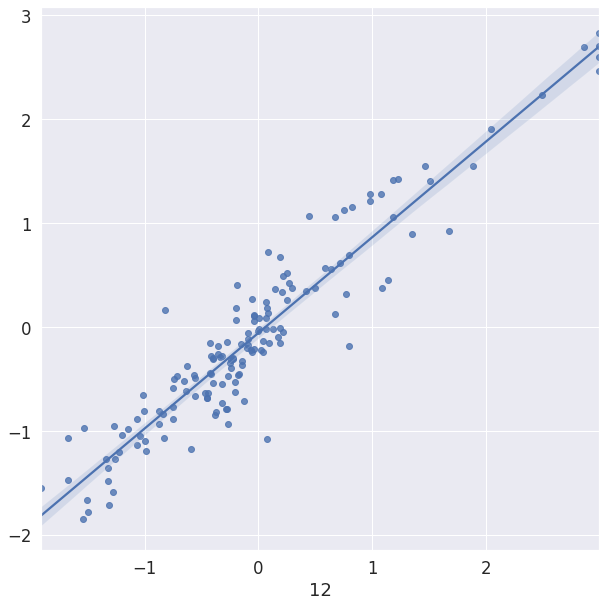

In [12]:
# DNN으로 예측
pred = model.predict(x=X_test)        #pred : 추측값
plt.figure(figsize=(10, 10))

sns.regplot(x=Y_test, y=pred)         # 정답과 추측값을 비교

# 인공지능의 회귀문제를 풀때, 인공신경망의 정확도를 시각화 하기 위해서 산포도를 주로 사용함.

In [13]:
print(type(X_test))
print(X_test.iloc[0])     # 파일형식이 Numpy인 경우에는 X_test[0]이여도 괜찮지만 pandas에서는 .iloc를 추가해줘야한다.
print(Y_test.iloc[0])

<class 'pandas.core.frame.DataFrame'>
0    -0.387983
1    -0.487722
2    -0.211099
3    -0.272599
4     0.261784
5    -0.510932
6    -0.923682
7    -0.671859
8    -0.408041
9    -0.102376
10    0.344213
11    0.131334
Name: 494, dtype: float64
0.21410439747436766
